# t検定
２群間の平均値の差の検定の行います。
このノートには、「1.対応のない2標本t検定」と「2.対応のある2標本t検定」の２つの事例を、それぞれ異なるサンプルデータを使って紹介しています。

汎用性の高い事例となるように、CSVデータを読み込んでから、検定に使えるデータに加工するという手順を踏んでいます。

このサンプルを参考に、自分でも様々なデータを使って検定を行なってみてください。
異なる条件が与えられた２つのグループ間に「差がある」ということがわかるだけで、学術論文が書けます。

付記：t検定の仮定として、データは以下の仮定を満たすものと見做します
* データが正規分布に従っている（正規性の仮定）
* 二群の分散が等しい（等分散性の仮定）


## 0. はじめに必要なライブラリを読み込みます

In [2]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

## 1. 対応のない t 検定

２つのグループ間には対応がない場合の検定です。  


### 1.1. サンプルデータの読み込み

統計学習のサンプルとして有名な iris.csv を使います。Irisは日本語で「アヤメ」。このデータセットには、setosa、versicolor、virginicaという3種の花に着目して、がく片（sepal）の長さ・幅、および花弁（petal）の長さ・幅を、それぞれ 50個体について測定しています。
* http://archive.ics.uci.edu/dataset/53/iris
* https://raw.githubusercontent.com/koichi-inoue/DataScience/main/iris.csv



In [3]:
# サンプルデータ iris.csv の読み込み
df = pd.read_csv('https://raw.githubusercontent.com/koichi-inoue/DataScience/main/iris.csv')
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


### 1.2. 比較するデータの準備
Versicolor種とVirginica種とで、「がく」の幅に差があるかを比較するために、上記のCSVファイルから、必要な部分のみを抽出します。

In [4]:
# Versicolor種の sepal.width（がくの幅）を df1 に抽出します
df1 = df.query( ' variety == "Versicolor" ')['sepal.width']
df1.describe()

,sepal.width
count,50.000000
mean,2.770000
std,0.313798
min,2.000000
25%,2.525000
50%,2.800000
75%,3.000000
max,3.400000


In [5]:
# Virginica種の sepal.width（がくの幅）を df2 に抽出します
df2 = df.query( ' variety == "Virginica" ')['sepal.width']
df2.describe()

,sepal.width
count,50.000000
mean,2.974000
std,0.322497
min,2.200000
25%,2.800000
50%,3.000000
75%,3.175000
max,3.800000


### 1.3. データをプロットして視覚的に確認
データの正規性や等分散性を簡易的に確認

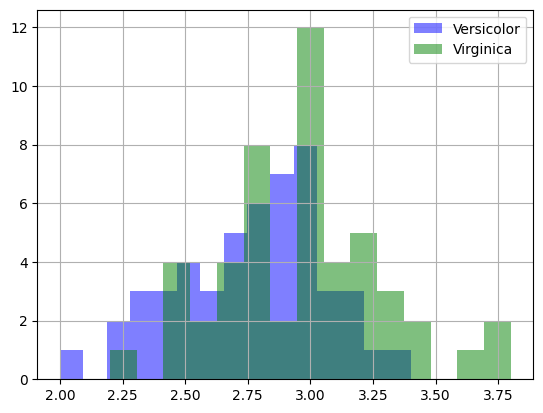

In [6]:
df1.hist( bins= 15, color="blue", alpha=0.5, label=f"Versicolor" )
df2.hist( bins= 15, color="green", alpha=0.5, label=f"Virginica" )
plt.legend()

### 1.4. データフォーマットの変換
統計ライブラリの関数を利用するために DataFrame を NumPy配列（ndarray）に変換します。

In [7]:
d1 = df1.values
print(type(d1))
print(d1)

<class 'numpy.ndarray'>
[3.2 3.2 3.1 2.3 2.8 2.8 3.3 2.4 2.9 2.7 2.  3.  2.2 2.9 2.9 3.1 3.  2.7
 2.2 2.5 3.2 2.8 2.5 2.8 2.9 3.  2.8 3.  2.9 2.6 2.4 2.4 2.7 2.7 3.  3.4
 3.1 2.3 3.  2.5 2.6 3.  2.6 2.3 2.7 3.  2.9 2.9 2.5 2.8]


In [8]:
d2 = df2.values
print(type(d2))
print(d2)

<class 'numpy.ndarray'>
[3.3 2.7 3.  2.9 3.  3.  2.5 2.9 2.5 3.6 3.2 2.7 3.  2.5 2.8 3.2 3.  3.8
 2.6 2.2 3.2 2.8 2.8 2.7 3.3 3.2 2.8 3.  2.8 3.  2.8 3.8 2.8 2.8 2.6 3.
 3.4 3.1 3.  3.1 3.1 3.1 2.7 3.2 3.3 3.  2.5 3.  3.4 3. ]


### 1.5. t検定

scipy.stats の関数を使います。  
対応のないt検定では、ttest_ind() 関数を使います。
* 等分散性があると仮定できる場合は、equal_var = Truth（スチューデントのt検定）
* 等分散性があると仮定できない場合は、equal_var = False（ウェルチのt検定）

両側検定を使うか、片側検定を使うか、目的によって以下を指定します。
* 両側検定：alternative='two-sided'
* 片側検定（少ない,小さい）：alternative=’less’
* 片側検定（多い,大きい）：alternative=’greater’

In [9]:
# 対応のないt検定：ttest_ind()
t, p = stats.ttest_ind(d1, d2, equal_var=True, alternative='two-sided')

print(f'p値 = {p:.5f}')
print(f't値 = {t:.3f}')

p値 = 0.00182
t値 = -3.206


実行例の場合、p<0.05 で「有意差あり」（帰無仮説は棄却）と判定されます。

## 2. 対応のある t 検定
２つのグループ間に対応がある場合（例えば、同一被験者に対して、２種類の異なる投薬を行なった場合の比較）の検定の事例です。

### 2.1. サンプルデータの読み込み

サンプルとして 統計ソフト R のデータセットに含まれる sleep.csv を使います。  
薬剤1と薬剤2の2種類の睡眠薬を10人の被験者に投与した際の、睡眠時間の差分を記録したデータで、2種類の薬剤を同一被験者に投与していることから、その値には対応があるといえます。
* https://rpubs.com/seafoam33/sleep1
* https://raw.githubusercontent.com/koichi-inoue/DataScience/main/sleep.csv

In [10]:
# サンプルデータ sleep.csv の読み込み
df = pd.read_csv('https://raw.githubusercontent.com/koichi-inoue/DataScience/main/sleep.csv')
df

,Unnamed: 0,extra,group,ID
0,1,0.7,1,1
1,2,-1.6,1,2
2,3,-0.2,1,3
3,4,-1.2,1,4
4,5,-0.1,1,5
5,6,3.4,1,6
6,7,3.7,1,7
7,8,0.8,1,8
8,9,0.0,1,9
9,10,2.0,1,10


### 2.2. データの準備

In [11]:
# group = 1 の extra（差分値）を df1 に抽出します
df1 = df.query( ' group == 1 ')['extra']
df1

,extra
0,0.7
1,-1.6
2,-0.2
3,-1.2
4,-0.1
5,3.4
6,3.7
7,0.8
8,0.0
9,2.0


In [12]:
# group = 2 の extra（差分値）を df2 に抽出します
df2 = df.query( ' group == 2 ')['extra']
df2

,extra
10,1.9
11,0.8
12,1.1
13,0.1
14,-0.1
15,4.4
16,5.5
17,1.6
18,4.6
19,3.4


### 2.3. データをプロットして視覚的に確認
ここでは「箱ひげ図」を使ってみます。  
データ数が少ないので何とも言えませんが、正規性があると仮定します。  
直感的には２つのグループには差があると感じられます。

<Axes: title={'center': 'extra'}, xlabel='group'>

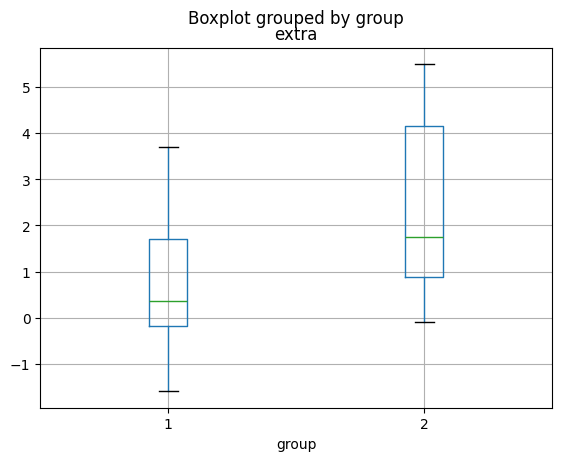

In [13]:
df.boxplot( column='extra' , by='group' )

###2.4. データフォーマットの変換
統計ライブラリの関数を利用するために DataFrame を NumPy配列（ndarray）に変換します。

In [14]:
d1 = df1.values
print(type(d1))
print(d1)

<class 'numpy.ndarray'>
[ 0.7 -1.6 -0.2 -1.2 -0.1  3.4  3.7  0.8  0.   2. ]


In [15]:
d2 = df2.values
print(type(d2))
print(d2)

<class 'numpy.ndarray'>
[ 1.9  0.8  1.1  0.1 -0.1  4.4  5.5  1.6  4.6  3.4]


### 2.5. t検定
対応のあるt検定は scipy.stats の ttest_rel() 関数を使います。


In [16]:
# 対応のある検定：ttest_rel()
t, p = stats.ttest_rel(d1, d2)

print(f'p値 = {p:.3f}')
print(f't値 = {t:.2f}')

p値 = 0.003
t値 = -4.06


実行例の場合、p<0.05 で「有意差あり」（帰無仮説は棄却）と判定されます。